<a href="https://colab.research.google.com/github/Vanessa-Maria2/simulador-de-banco-de-sangue/blob/main/Modelagem_doa%C3%A7%C3%A3o_de_sangue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import random

In [2]:
tiposSanquineo = ["O+", "A+", "B+", "AB+", "O-", "A-", "B-", "AB-"]
probTipoSanguineo  = [0.36, 0.34, 0.08, 0.025, 0.09, 0.08, 0.02, 0.005]

In [3]:
from dataclasses import dataclass
from enum import Enum

class TipoSangue(Enum):
  O_POS = "O+"
  A_POS = "A+"
  B_POS = "B+"
  AB_POS = "AB+"
  O_NEG = "O-"
  A_NEG = "A-"
  B_NEG = "B-"
  AB_NEG = "AB-"

  @staticmethod
  def random():
    return TipoSangue(random.choices(tiposSanquineo, probTipoSanguineo)[0])

  def compativeis(self) -> set:
    compatibilidade = {
      "O-": {"O-"},
      "O+": {"O-", "O+"},
      "A-": {"O-", "A-"},
      "A+": {"O-", "O+", "A-", "A+"},
      "B-": {"O-", "B-"},
      "B+": {"O-", "O+", "B-", "B+"},
      "AB-": {"O-", "A-", "B-", "AB-"},
      "AB+": {"O-", "O+", "A-", "A+", "B-", "B+", "AB-", "AB+"}
    }

    return {
       TipoSangue(t) for t in compatibilidade[self.value]
    }

  def __str__(self) -> str:
    return f'{self.value}'

  def __repr__(self):
    return self.__str__()

@dataclass
class BolsaSangue:
  tipo: TipoSangue
  dia_criado: int
  dia_doado: int | None

  def __str__(self) -> str:
    return f'({self.tipo.value}, C:{self.dia_criado}, D:{self.dia_doado or '-'})'
  def __repr__(self):
    return self.__str__()

@dataclass
class Demanda:
  tipo: TipoSangue
  dias_de_espera: int = 0

In [4]:
def cria_random_doadores(qtd_doadores, dia) -> list[BolsaSangue]:
  doadores = []
  for i in range(qtd_doadores):
     doadores.append(
            BolsaSangue(
                tipo=TipoSangue.random(),
                dia_criado=dia,
                dia_doado=None
            )
        )

  return doadores

def cria_random_demanda(qtd_demanda) -> list[Demanda]:
   return [Demanda(tipo=TipoSangue.random(), dias_de_espera=0) for _ in range(qtd_demanda)]

In [8]:


def pegarBolsaMaisVelha(banco_de_sangue: list[BolsaSangue], tipo_requisitado: TipoSangue) -> int | None:
  tipos_compatives = tipo_requisitado.compativeis()
  posicoes_compativeis = [
    i
    for i, el in enumerate(banco_de_sangue)
    if (el.tipo in tipos_compatives and el.dia_doado == None)
  ]

  if not posicoes_compativeis:
    return None

  ordered = sorted(posicoes_compativeis, key=lambda i : banco_de_sangue[i].dia_criado)

  return ordered[0]

def pegarBolsaComMaisQuantidade(banco_de_sangue: list[BolsaSangue], tipo_requisitado: TipoSangue) -> int | None:
  tipos_compatives = tipo_requisitado.compativeis()
  bolsas_disponiveis_e_compativeis = [
    i
    for i, el in enumerate(banco_de_sangue)
    if (el.tipo in tipos_compatives and el.dia_doado is None)
  ]

  if not bolsas_disponiveis_e_compativeis:
    return None

  contador = {}

  for i in bolsas_disponiveis_e_compativeis:
    tipo = banco_de_sangue[i].tipo
    if tipo in contador:
      contador[tipo] += 1
    else:
      contador[tipo] = 1

  tipo_sangue_com_mais_bolsas_no_estoque = max(contador, key=contador.get)

  return next(i for i, el in enumerate(banco_de_sangue) if (el.tipo == tipo_sangue_com_mais_bolsas_no_estoque and el.dia_doado is None))


In [6]:
def gera_dias(
    qtd_dias: int,
    media_doadores: float,
    media_demanda: float,
    seed: int | None = None
) -> list[tuple[int, int]]:
    if seed is not None:
        seed = int(seed)

    rng = np.random.default_rng(seed)

    return [
        (
            rng.poisson(media_demanda),
            rng.poisson(media_doadores)
        )
        for _ in range(qtd_dias)
    ]

In [7]:
import csv

def salva_resumo_csv(nome_arquivo, registros):
    """
    registros: lista de dicts, um por dia
    """
    with open(nome_arquivo, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=[
                "dia",
                "qtd_doadores",
                "qtd_demanda",
                "qtd_banco",
                "qtd_espera"
            ]
        )
        writer.writeheader()
        writer.writerows(registros)


In [10]:
from itertools import chain

banco_de_sangue: list[BolsaSangue] = []

# (qtd_demanda, qtd_doadores)
dias = [
    (0,3),
    (0,10),
    (0,8),
    (6,0),
    (7,0),
    (8,0),
    (15,0),
]

novos_dias = gera_dias(
    qtd_dias=10,
    media_doadores=10.0,
    media_demanda=10.0,
    seed=42
)

dias.extend(novos_dias)

print(dias)

@dataclass
class Registro:
  dia: int
  dias_espera: int
  idade_sangue: int
  tipo_demanda: TipoSangue
  tipo_doado: TipoSangue

registro = []

resumo_dias = []

lista_de_espera: list[Demanda] = []

for dia, (qtd_demanda, qtd_doadores) in enumerate(dias):
  novos_doadores = cria_random_doadores(qtd_doadores, dia)
  nova_demanda = cria_random_demanda(qtd_demanda)

  print(f'\n\nQTD Doadores: {len(novos_doadores)}')
  print(f'QTD demanda: {len(nova_demanda)}')


  print(f'DIA {dia} => nova_demanda: {nova_demanda}')
  print(f'DIA {dia} => novos_doadores: {novos_doadores}')
  print(f'DIA {dia} => banco: {banco_de_sangue}')
  print(f'DIA {dia} => lista_de_espera: {lista_de_espera}')

  nao_conseguiu_doacao = []

  for demanda in chain(lista_de_espera, nova_demanda):
    bolsa_escolhida = pegarBolsaComMaisQuantidade(banco_de_sangue, demanda.tipo)

    if bolsa_escolhida == None:
      demanda.dias_de_espera += 1
      nao_conseguiu_doacao.append(demanda)
    else:
      registro.append(
          Registro(
              dia=dia,
              dias_espera=demanda.dias_de_espera,
              idade_sangue=(dia - banco_de_sangue[bolsa_escolhida].dia_criado),
              tipo_demanda=demanda.tipo,
              tipo_doado=banco_de_sangue[bolsa_escolhida].tipo,
          )
      )
      banco_de_sangue[bolsa_escolhida].dia_doado = dia
      print(f'Bolsa escolhida: { banco_de_sangue[bolsa_escolhida]}, Indice: {bolsa_escolhida}')

  lista_de_espera = nao_conseguiu_doacao

  print(f'DIA {dia} => registro: {registro}')

  banco_de_sangue.extend(novos_doadores)
  estoque = [i for i in banco_de_sangue if i.dia_doado is None]

  print(f'QTD BS total: {len(banco_de_sangue)} ')
  print(f'QTD BS filtrada: {len(estoque)} ')

  resumo_dias.append({
        "dia": dia,
        "qtd_doadores": len(novos_doadores),
        "qtd_demanda": len(nova_demanda),
        "qtd_banco": len(estoque),
        "qtd_espera": len(lista_de_espera)
    })

  salva_resumo_csv("resumo_simulacao.csv", resumo_dias)


print('-------------')
print('registro final')
print(registro)



[(0, 3), (0, 10), (0, 8), (6, 0), (7, 0), (8, 0), (15, 0), (13, 6), (9, 11), (9, 10), (13, 13), (13, 10), (6, 8), (10, 6), (7, 9), (12, 9), (12, 7)]


QTD Doadores: 3
QTD demanda: 0
DIA 0 => nova_demanda: []
DIA 0 => novos_doadores: [(O+, C:0, D:-), (O+, C:0, D:-), (A-, C:0, D:-)]
DIA 0 => banco: []
DIA 0 => lista_de_espera: []
DIA 0 => registro: []
QTD BS total: 3 
QTD BS filtrada: 3 


QTD Doadores: 10
QTD demanda: 0
DIA 1 => nova_demanda: []
DIA 1 => novos_doadores: [(O+, C:1, D:-), (A+, C:1, D:-), (B-, C:1, D:-), (B-, C:1, D:-), (A-, C:1, D:-), (O-, C:1, D:-), (A+, C:1, D:-), (O+, C:1, D:-), (O+, C:1, D:-), (O-, C:1, D:-)]
DIA 1 => banco: [(O+, C:0, D:-), (O+, C:0, D:-), (A-, C:0, D:-)]
DIA 1 => lista_de_espera: []
DIA 1 => registro: []
QTD BS total: 13 
QTD BS filtrada: 13 


QTD Doadores: 8
QTD demanda: 0
DIA 2 => nova_demanda: []
DIA 2 => novos_doadores: [(A-, C:2, D:-), (O+, C:2, D:-), (O+, C:2, D:-), (O+, C:2, D:-), (O-, C:2, D:-), (O+, C:2, D:-), (A+, C:2, D:-), (B+, C:2, D:-

<Axes: xlabel='dia'>

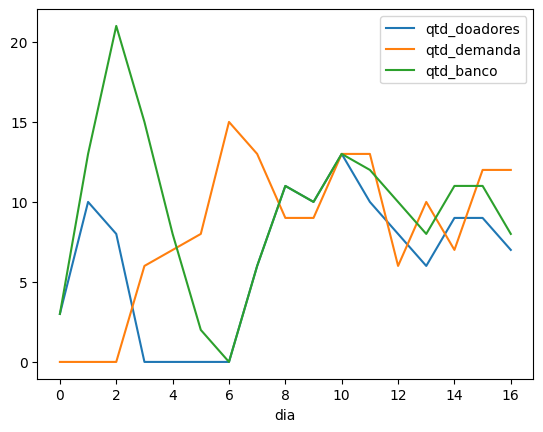

In [11]:
df = pd.read_csv("resumo_simulacao.csv")

df.plot(x="dia", y=["qtd_doadores", "qtd_demanda", "qtd_banco"])